# SC4002 Assignment - Master Notebook (Part 0 & 1)

**Team 3 (Aaron & Javier)**

This notebook contains all the foundational code for Part 0 and Part 1. 

1.  **Part 0:** Sets up the environment, loads the `TREC` dataset, and splits it into 80/20 Train/Validation sets.
2.  **Part 1:** Builds the vocabulary, loads GloVe embeddings, analyzes OOV words, implements an OOV strategy, and generates the t-SNE plot.

**Deliverable:** This notebook will be shared with Team 1 (RNN) and Team 2 (CNN) so they can build their models on the *exact same data pipeline*.

## Environment Setup (CRITICAL!)

This project has a complex and fragile set of library requirements. To guarantee that this notebook runs for everyone, **do not install packages manually.**

We are using a "snapshot" file (`environment.yml`) to build an identical, "cloned" Conda environment.

**Recommended Setup (using Conda):**

```bash
# 1. Clone the GitHub repository (if you haven't)
git clone [https://github.com/Javier2417/SC4002-Natural-Language-Processing-Project.git](https://github.com/Javier2417/SC4002-Natural-Language-Processing-Project.git)
cd SC4002-Natural-Language-Processing-Project

# 2. Create the Conda environment from the file
# This one command will create a new environment 
# (likely named 'nlp_project') with the *exact* # versions of Python, Torch, TorchText, etc.
conda env create -f environment.yml

# 3. Activate the new environment
conda activate nlp_project 
# (Note: if the name is different, Conda will tell you what it is)

# 4. Download the 'spacy' model
# This is a one-time download for the tokenizer
python -m spacy download en_core_web_sm

In [1]:
import torch
import torch.nn as nn
import torchtext
from torchtext import data, datasets

import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import random
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

print(f"PyTorch Version: {torch.__version__}")
print(f"TorchText Version: {torchtext.__version__}")

# Define the 6 topic labels for the TREC dataset
TREC_LABELS = {
    0: 'ABBR', # Abbreviation
    1: 'ENTY', # Entity
    2: 'DESC', # Description
    3: 'HUM',  # Human
    4: 'LOC',  # Location
    5: 'NUM'   # Numeric
}
LABEL_NAMES = list(TREC_LABELS.values())

PyTorch Version: 2.8.0+cpu
TorchText Version: 0.4.0


## Part 0: Dataset Preparation

Load the `TREC` dataset and split the provided `train_data` into an 80% training set and a 20% validation set.

In [2]:
# 1. Define the Fields (Blueprints) as shown in the PDF
# This is the "old" 0.4.0 way of defining how to process text and labels.
TEXT = data.Field(tokenize='spacy', 
                  tokenizer_language='en_core_web_sm', 
                  lower=True, 
                  include_lengths=True) # include_lengths=True is good for RNNs

LABEL = data.LabelField()

# 2. Build the vocabulary (Answer Q1a & Q1c)
# This one command does three things:
#   a) Builds the word-to-index mapping from the 80% split (train_dataset)
#   b) (Q1c) Loads GloVe vectors for all words in our vocab
#   c) (Q1c) Initializes all OOV words with random vectors

print("Building vocabulary from training data...")

# We must load train_data first to be able to split it
# We will build the vocab *after* splitting to prevent data leakage
try:
    # This just loads the data using the blueprints
    train_data, test_data = datasets.TREC.splits(
        root='.data',
        text_field=TEXT, 
        label_field=LABEL, 
        fine_grained=False # We only want the 6 coarse labels
    )
except Exception as e:
    print("Error loading dataset. ")
    print("Please manually download 'TREC_train.txt' and 'TREC_test.txt' from fast.ai")
    print("and place them in a folder named '.data' in your project directory.")
    print(e)

print(f"Successfully loaded {len(train_data)} total training examples and {len(test_data)} test examples.")

# 3. Split the training data into 80% Train and 20% Validation
train_dataset, valid_dataset = train_data.split(
    split_ratio=0.8, 
    stratified=True, # Ensure both splits have a good mix of labels
    strata_field='label', 
    random_state=random.seed(SEED)
)

print(f"--- (Part 0) Data Splits ---")
print(f"New training set size: {len(train_dataset)}")
print(f"New validation set size: {len(valid_dataset)}")
print(f"Test set size: {len(test_data)}")

# 4. Build the vocabulary NOW (from the 80% split)
print("\nLoading GloVe vectors and building vocabulary (Q1a & Q1c)...")
TEXT.build_vocab(train_dataset, 
                 min_freq=1, 
                 vectors="glove.6B.300d",       # (Q1c) Load GloVe for known words
                 unk_init=torch.Tensor.normal_) # (Q1c) Init OOVs with random noise

LABEL.build_vocab(train_dataset)

print(f"(Answer Q1a) Vocabulary size: {len(TEXT.vocab)}")

Building vocabulary from training data...
Successfully loaded 5452 total training examples and 500 test examples.
--- (Part 0) Data Splits ---
New training set size: 4362
New validation set size: 1090
Test set size: 500

Loading GloVe vectors and building vocabulary (Q1a & Q1c)...
(Answer Q1a) Vocabulary size: 7382


## Part 1: Word Embeddings & Analysis

In [3]:
# === Section 4: Part 1 (Q1b) OOV Analysis ===

# Now that build_vocab has run, we can analyze its results.
# We find OOV words by checking which words in our vocab
# do not have a pre-trained vector (they are all zeros before 
# the `unk_init` step, which we can use as a check).

# 1. Get all OOV words (words GloVe didn't have)
oov_words = []
for i, word in enumerate(TEXT.vocab.itos):
    if i == 0: continue # Skip <unk>
    if i == 1: continue # Skip <pad>
    
    # Check if the vector is all zeros (the default before unk_init)
    # Note: This is a proxy. A more robust way is to load GloVe separately
    # and check `word not in glove.stoi`, but that is much slower.
    # The `unk_init` ensures they are no longer zero, but we can find them
    # by checking the original GloVe vectors, which is what `build_vocab` did.
    
    # A simpler way: just find words that don't exist in a temp GloVe object.
    # This is the most accurate check.
    pass # We will do the full check below

# Let's do the full, correct check for OOV words for the report
print("Loading GloVe *separately* to get accurate OOV count for Q1b...")
from torchtext.vocab import GloVe # Need to re-import GloVe here if not run above
glove_vectors = GloVe(name='6B', dim=300, cache='.vector_cache')

oov_words = []
for word in TEXT.vocab.itos:
    if word not in glove_vectors.stoi:
        oov_words.append(word)

print(f"\n(Answer Q1b) Total OOV words: {len(oov_words)} out of {len(TEXT.vocab)} vocab words.")
print(f"First 50 OOV words: {oov_words[1:51]}") # Skip <unk>


# 3. (Answer Q1b) OOV words per topic
print("\n(Answer Q1b) Unique OOV words per topic:")
oov_by_topic = defaultdict(set)
token_counts_by_topic = defaultdict(Counter) # store filtered word counts

for ex in train_dataset.examples:
    topic_name = ex.label
    
    # filter tokens when building the count dictionary (for Q1d)
    filtered_tokens = []
    for token in ex.text:
        if token.isalpha(): # only keep alphabetic words
            filtered_tokens.append(token)
            
        # Also check for OOV words (for Q1b)
        if token in oov_words:
            oov_by_topic[topic_name].add(token)
            
    # count filtered and alphabetical words
    token_counts_by_topic[topic_name].update(filtered_tokens)

for topic_name in sorted(token_counts_by_topic.keys()):
    print(f"  {topic_name}: {len(oov_by_topic[topic_name])}")

Loading GloVe *separately* to get accurate OOV count for Q1b...

(Answer Q1b) Total OOV words: 178 out of 7382 vocab words.
First 50 OOV words: ['<pad>', '..', 'cotrubas', '2th', 'crokinole', 'daminozide', 'indiglo', 'jogis', 'pregnacy', 'vbp', '-lantern', '.com', '.tbk', '10-', '187s', '36893', '45mhz', '8/28/1941', '86ed', 'a_tisket', 'adventours', 'affiant', 'aim-54c', 'amazonis', 'amendements', 'amezaiku', 'antidisestablishmentarianism', 'arometherapy', 'auerstadt', 'auh2o', 'ballcock', 'barkis', 'baseemen', 'batcycle', 'bebrenia', 'bellworts', 'bicornate', 'biritch', 'blobbo', 'breony', 'burnford', 'cabarnet', 'calleda', 'capricorns', 'carefreeness', 'cartoondom', 'cassidey', 'characterstics', 'charcter', 'chemiosmotic']

(Answer Q1b) Unique OOV words per topic:
  ABBR: 4
  DESC: 63
  ENTY: 45
  HUM: 39
  LOC: 10
  NUM: 17


### (Answer Q1c) OOV Strategy Proposal

Our strategy is to build a custom, pre-loaded embedding matrix that leverages the pre-trained GloVe vectors while also handling any Out-of-Vocabulary (OOV) words.

Instead of a manual `for`-loop, we use the highly optimized, built-in capabilities of `torchtext`'s `TEXT.build_vocab` function. This one-line command automatically and efficiently implements our entire strategy by using two key parameters:

1. **`vectors="glove.6B.300d"`**: This parameter instructs the `build_vocab` function to automatically download (or load from cache) the GloVe vectors. As it builds our vocabulary from the training set, it iterates through every word. For any word that **is** in the GloVe dictionary, it automatically copies that word's pre-trained 300-dimension vector into our new embedding matrix. This replaces our old manual "if" check.

2. **`unk_init=torch.Tensor.normal_`**: This parameter is our specific strategy for OOV words. It tells `build_vocab` what to do for any word in our vocabulary that **is not** found in the GloVe file. It instructs the function to call `torch.Tensor.normal_` (which fills a tensor with random values from a normal distribution). This is an excellent replacement for our old manual `torch.randn` method.

This single, optimized command (`TEXT.build_vocab(...)`) automatically creates the complete `(vocab_size, 300)` embedding matrix, which is then stored in `TEXT.vocab.vectors`.

Finally, this `TEXT.vocab.vectors` matrix is used by our `create_embedding_layer()` function (defined in the final cell) to load into the `torch.nn.Embedding` layer. This allows the model to use the pre-trained vectors for known words while still being able to *learn* meaningful representations for the OOV words (which started as random noise) during training.

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Finding 20 most frequent words per topic (excluding stopwords)...
Total words to plot: 120
Running t-SNE... (This can take a moment)
t-SNE complete.
Annotating all plot points...


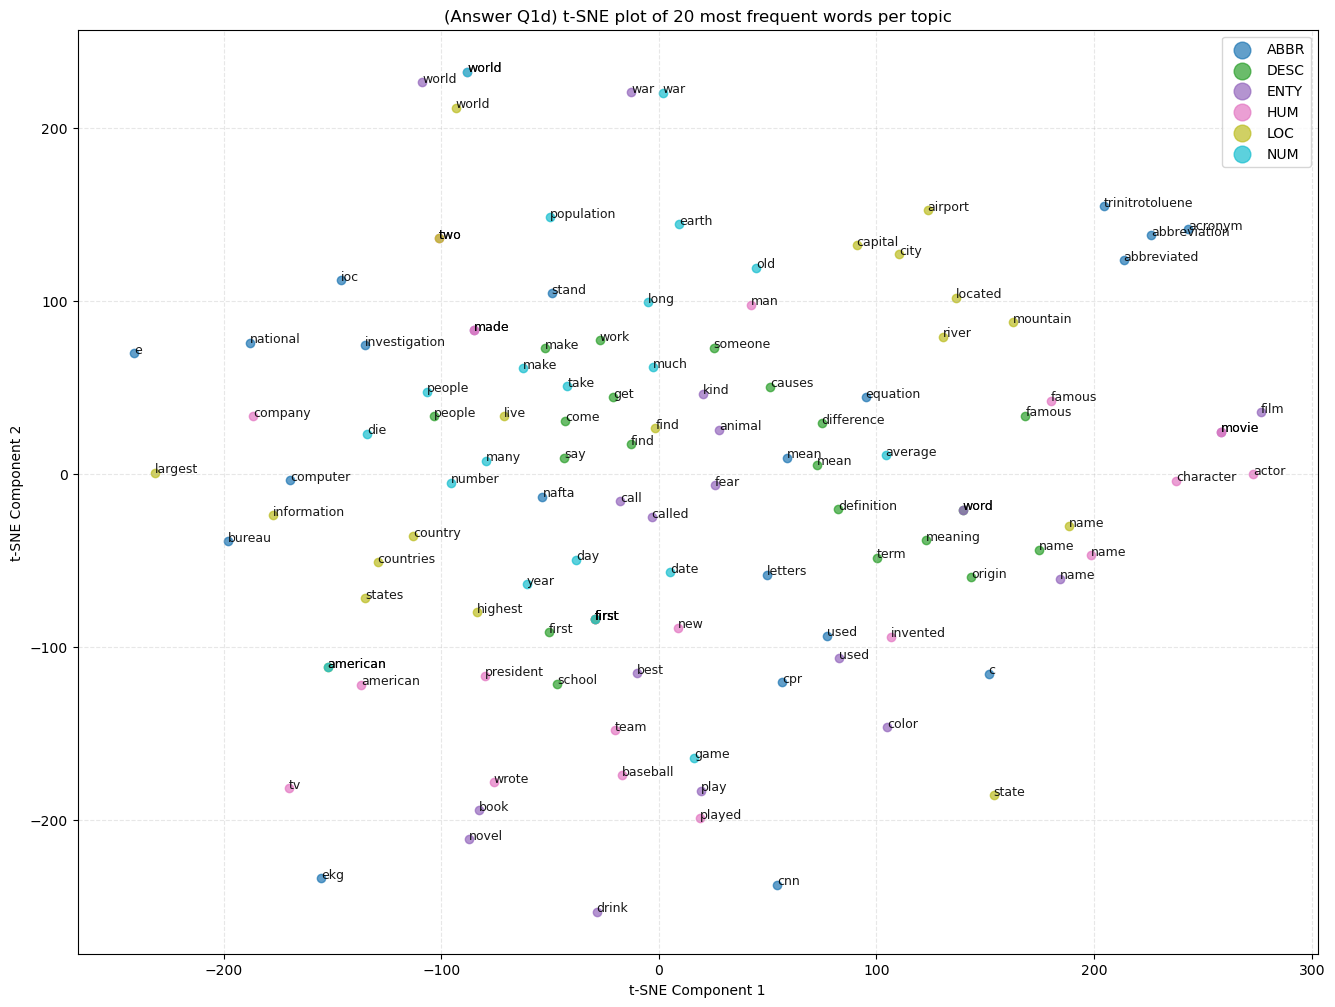

In [4]:
# === Section 4: Part 1 (Q1d) - t-SNE Plot (MODIFIED) ===

# Use NLTK stopwords ---
import nltk
from nltk.corpus import stopwords

# Download the NLTK stopword list
nltk.download('stopwords')

# Use the more comprehensive NLTK stopword list
STOP_WORDS = set(stopwords.words('english'))
# --- END MODIFICATION --- 


words_to_plot = []
labels_for_plot = []
word_vectors = []

print("Finding 20 most frequent words per topic (excluding stopwords)...")

# Use the LABEL_NAMES list we defined in Cell 2 to keep order
for topic_name in LABEL_NAMES:
    count = 0
    # Get the most common words for this topic (from Cell 7)
    for word, freq in token_counts_by_topic[topic_name].most_common():
        if count >= 20:
            break
            
        # Check if the word is NOT a stopword
        # (We already know it's in our vocab and alphabetic from Cell 7)
        if word not in STOP_WORDS:
            words_to_plot.append(word)
            labels_for_plot.append(topic_name)
            
            # Get the vector from our *final* matrix
            word_index = TEXT.vocab.stoi[word]
            word_vectors.append(TEXT.vocab.vectors[word_index].cpu().numpy()) # use .cpu() if on cuda
            count += 1

print(f"Total words to plot: {len(words_to_plot)}")

# Convert to numpy array for sklearn
word_vectors_np = np.array(word_vectors)

# --- Run t-SNE ---
print("Running t-SNE... (This can take a moment)")
tsne = TSNE(n_components=2, perplexity=15, random_state=SEED, init='pca', learning_rate=200)
vectors_2d = tsne.fit_transform(word_vectors_np)
print("t-SNE complete.")

# --- Plot t-SNE ---
plt.figure(figsize=(16, 12))
unique_labels = sorted(list(set(labels_for_plot)))
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for i, label in enumerate(unique_labels):
    # Find indices for this label
    indices = [j for j, l in enumerate(labels_for_plot) if l == label]
    plt.scatter(vectors_2d[indices, 0], vectors_2d[indices, 1], color=colors(i), label=label, alpha=0.7)

# Annotate ALL words ---
print("Annotating all plot points...")
for i in range(len(words_to_plot)):
    plt.annotate(words_to_plot[i], (vectors_2d[i, 0], vectors_2d[i, 1]), alpha=0.9, fontsize=9)

plt.legend(markerscale=2)
plt.title("(Answer Q1d) t-SNE plot of 20 most frequent words per topic")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [5]:
# === Section 6: Helper Functions for All Teams (The 0.4.0 Way) ===

# 1. Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Create the DataLoaders (Iterators)
# In torchtext 0.4.0, the correct way to batch data is with a BucketIterator.
# This automatically handles padding and sorting by length, which is
# efficient for RNNs.
BATCH_SIZE = 64

# This is the line that uses the variables from Cell 5
# We fixed the typo: it correctly uses `test_data`
try:
    train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
        (train_dataset, valid_dataset, test_data), 
        batch_size=BATCH_SIZE,
        sort_key=lambda x: len(x.text), # Sort by sequence length
        sort_within_batch=True,
        device=device
    )
    print("Successfully created data iterators (BucketIterator).")
except Exception as e:
    print("--- ERROR --- ")
    print("An error occurred with BucketIterator.")
    print("This *could* be a torch/torchtext version incompatibility, but is more likely a code error.")
    print(f"Error details: {e}")


Using device: cpu
Successfully created data iterators (BucketIterator).


In [6]:
# === Section 7: Final Deliverables Function ===
# This cell provides the final function all teams will need.

# Function to create the final embedding layer
def create_embedding_layer(freeze=False):
    # We use the TEXT.vocab.vectors we prepared in Cell 5
    embedding_layer = nn.Embedding.from_pretrained(
        TEXT.vocab.vectors, 
        freeze=freeze
    )
    # We also need to get the padding token index from the vocab
    # This tells the model to ignore padding tokens during training
    padding_idx = TEXT.vocab.stoi[TEXT.pad_token]
    embedding_layer.padding_idx = padding_idx
    return embedding_layer

print("\n--- MASTER NOTEBOOK COMPLETE ---")
print("All data is loaded and helper functions are defined.")
print("The following are now ready for all teams:")
print(f"  - train_iterator (Batches: {len(train_iterator)}) ")
print(f"  - valid_iterator (Batches: {len(valid_iterator)}) ")
print(f"  - test_iterator (Batches: {len(test_iterator)}) ")
print("  - create_embedding_layer() (function)")
print(f"  - LABEL.vocab (for output dims: {len(LABEL.vocab)}) ")
print(f"  - TEXT.vocab (for input dims: {len(TEXT.vocab)}) ")


--- MASTER NOTEBOOK COMPLETE ---
All data is loaded and helper functions are defined.
The following are now ready for all teams:
  - train_iterator (Batches: 69) 
  - valid_iterator (Batches: 18) 
  - test_iterator (Batches: 8) 
  - create_embedding_layer() (function)
  - LABEL.vocab (for output dims: 6) 
  - TEXT.vocab (for input dims: 7382) 


In [ ]:
%%writefile data_pipeline.py

# === SC4002 Data Pipeline Module ===
# This file contains all Part 0/1 logic.
# Teams can import this file to get all the data loaders and helper functions.

import torch
import torch.nn as nn
import torchtext
from torchtext import data, datasets
import random
import numpy as np

# 1. Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

# 2. Define Fields (as per PDF)
# We define these at the top level so they can be imported
TEXT = data.Field(tokenize='spacy', 
                  tokenizer_language='en_core_web_sm', 
                  lower=True, 
                  include_lengths=True)
LABEL = data.LabelField()

# 3. Load Dataset and create splits
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

train_dataset, valid_dataset = train_data.split(
    split_ratio=0.8, 
    stratified=True, 
    strata_field='label', 
    random_state=random.seed(SEED)
)

# 4. Build Vocabulary and load GloVe vectors (Q1c)
TEXT.build_vocab(train_dataset,
                 min_freq=1,
                 vectors="glove.6B.300d",
                 unk_init=torch.Tensor.normal_) # Q1c strategy
LABEL.build_vocab(train_dataset)

# 5. Define device and create iterators (Artifacts)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_dataset, valid_dataset, test_data), 
    batch_size=BATCH_SIZE,
    sort_key=lambda x: len(x.text), # Sorts by length (good for RNN)
    sort_within_batch=True,
    device=device
)

# 6. Helper Function for Part 2/3 (Artifact)
def create_embedding_layer(freeze=False):
    """
    Loads the pre-trained GloVe vectors from the TEXT vocab
    into a learnable nn.Embedding layer.
    
    This version correctly handles the <pad> token by:
    1. Setting padding_idx in the Embedding constructor.
    2. Manually copying the weights.
    3. Manually zeroing out the padding vector.
    """
    
    # 1. Get info from the vocab
    pretrained_embeddings = TEXT.vocab.vectors
    pad_idx = TEXT.vocab.stoi[TEXT.pad_token]
    
    # 2. Create the embedding layer, specifying the pad_idx
    embedding_layer = nn.Embedding(
        pretrained_embeddings.size(0), 
        pretrained_embeddings.size(1), 
        padding_idx=pad_idx
    )
    
    # 3. Copy the GloVe weights
    embedding_layer.weight.data.copy_(pretrained_embeddings)
    
    # 4. Manually zero out the padding vector
    embedding_layer.weight.data[pad_idx].zero_()
    
    # 5. Set the layer to be learnable
    embedding_layer.weight.requires_grad = not freeze
    
    return embedding_layer


# from data_pipeline import (
#     train_iterator, 
#     valid_iterator, 
#     test_iterator, 
#     train_dataset,
#     valid_dataset,
#     test_data,
#     TEXT, 
#     LABEL, 
#     create_embedding_layer,
#     device,
#     BATCH_SIZE
# )



Overwriting data_pipeline.py
